In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from matplotlib.colors import from_levels_and_colors
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta

from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)

In [4]:
# USER INPUTS
# ----------------------------------------------

# File path.
fp = (r'/Users/alexyoung/Desktop/Cornell/Classes/Spring_2021/EAS_5555-Numerical_Climate_Modeling/'
      'WRF_Runs/DATA/Mar-30-Forecast/wrfout_d03_2021-03-30_12:00:00')

# Geopotential height in hPa to interpolate to.
gph = 500

# Start date/time of forecast YYYY-mm-dd HH:MM:SS
start_date = '2021-03-30 12:00:00'

# GIF save name.
gif_name = 'mar_30_dbz.gif'

# Spacing between wind barbs. Plots every nth grid point.
n_gap = 10

# Frame interval in ms.
frame_interval = 250

61


MovieWriter Pillow unavailable; using Pillow instead.


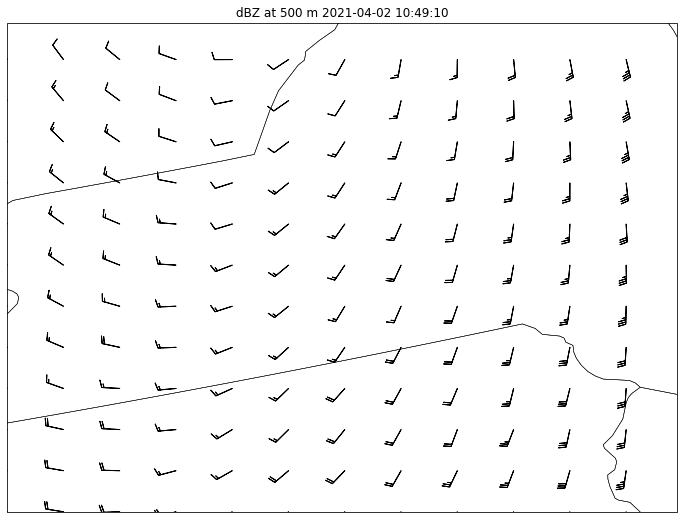

In [3]:
# Open the NetCDF file
ncfile = Dataset(fp)

# Get number of time intervals.
Nt = ncfile.dimensions['Time'].size

# Extract variables to initialize the figure.
p = getvar(ncfile, "pressure", timeidx=1)
z = getvar(ncfile, "z", units="dm", timeidx=1)

# Interpolate geopotential height, u, and v winds to 500 hPa
ht_gph = interplevel(z, p, gph)

# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_gph)

# Get the map projection information
cart_proj = get_cartopy(ht_gph)

# Create the color table found on NWS pages.
dbz_levels = np.arange(5., 75, 5.)
dbz_rgb = np.array([[4,233,231],
                    [1,159,244], [3,0,244],
                    [2,253,2], [1,197,1],
                    [0,142,0], [253,248,2],
                    [229,188,0], [253,149,0],
                    [253,0,0], [212,0,0],
                    [188,0,0],[248,0,253],
                    [152,84,198]], np.float32) / 255.0

dbz_map, dbz_norm = from_levels_and_colors(dbz_levels, dbz_rgb,
                                           extend="max")

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")

# Create a list of dates.
Nt = ncfile.dimensions['Time'].size
dt = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
dt_str = datetime.strftime(dt, '%Y-%m-%d %H:%M:%S')
hour_dt = 72 / Nt
dates = []
for i in range(Nt):
    dates.append(dt_str)
    dt = dt + timedelta(hours=hour_dt)
    dt_str = datetime.strftime(dt, '%Y-%m-%d %H:%M:%S')

def animate(i):
    ax.clear()
    
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)
    
    # Extract variables.
    p = getvar(ncfile, "pressure", timeidx=i)
    z = getvar(ncfile, "z", units="dm", timeidx=i)
    dbz = getvar(ncfile, "dbz", timeidx=i)
    ua = getvar(ncfile, "ua", units="kt", timeidx=i)
    va = getvar(ncfile, "va", units="kt", timeidx=i)

    # Compute the reflectivity. 
    Z = 10**(dbz/10.) # Use linear Z for interpolation

    # Interpolate geopotential height, u, and v winds to gph hPa
    ht_gph = interplevel(z, p, gph)
    u_gph = interplevel(ua, p, gph)
    v_gph = interplevel(va, p, gph)
    Z_gph = interplevel(Z, p, gph)

    # Convert back to dbz
    dbz_gph = 10.0 * np.log10(Z_gph)

    # Get the lat/lon coordinates
    lats, lons = latlon_coords(ht_gph)
    
    # Add the reflectivity.
    dbz_contour = plt.contourf(to_np(lons), to_np(lats), to_np(dbz_gph),
                            levels=dbz_levels,
                            cmap=dbz_map,
                            norm=dbz_norm,
                            transform=crs.PlateCarree())
    
    # Add the gph hPa wind barbs, only plotting every nth data point.
    barb_contour = plt.barbs(to_np(lons[::n_gap,::n_gap]), to_np(lats[::n_gap,::n_gap]),
          to_np(u_gph[::n_gap, ::n_gap]), to_np(v_gph[::n_gap, ::n_gap]),
          transform=crs.PlateCarree(), length=6)

    
    ax.set_title('dBZ at {} m {}'.format(gph, dates[i]))
    ax.set_aspect('auto')

anim = FuncAnimation(fig, animate, frames=Nt, interval=frame_interval)
anim.save(gif_name, writer='Pillow')

In [5]:
print(ncfile.variables.keys())

dict_keys(['Times', 'XLAT', 'XLONG', 'LU_INDEX', 'ZNU', 'ZNW', 'ZS', 'DZS', 'VAR_SSO', 'U', 'V', 'W', 'PH', 'PHB', 'T', 'THM', 'HFX_FORCE', 'LH_FORCE', 'TSK_FORCE', 'HFX_FORCE_TEND', 'LH_FORCE_TEND', 'TSK_FORCE_TEND', 'MU', 'MUB', 'NEST_POS', 'P', 'PB', 'FNM', 'FNP', 'RDNW', 'RDN', 'DNW', 'DN', 'CFN', 'CFN1', 'THIS_IS_AN_IDEAL_RUN', 'P_HYD', 'Q2', 'T2', 'TH2', 'PSFC', 'U10', 'V10', 'RDX', 'RDY', 'RESM', 'ZETATOP', 'CF1', 'CF2', 'CF3', 'ITIMESTEP', 'XTIME', 'QVAPOR', 'QCLOUD', 'QRAIN', 'QICE', 'QSNOW', 'QGRAUP', 'QNICE', 'QNRAIN', 'SHDMAX', 'SHDMIN', 'SNOALB', 'TSLB', 'SMOIS', 'SH2O', 'SMCREL', 'SEAICE', 'XICEM', 'SFROFF', 'UDROFF', 'IVGTYP', 'ISLTYP', 'VEGFRA', 'GRDFLX', 'ACGRDFLX', 'ACSNOM', 'SNOW', 'SNOWH', 'CANWAT', 'SSTSK', 'COSZEN', 'LAI', 'DTAUX3D', 'DTAUY3D', 'DUSFCG', 'DVSFCG', 'VAR', 'CON', 'OA1', 'OA2', 'OA3', 'OA4', 'OL1', 'OL2', 'OL3', 'OL4', 'TKE_PBL', 'EL_PBL', 'MAPFAC_M', 'MAPFAC_U', 'MAPFAC_V', 'MAPFAC_MX', 'MAPFAC_MY', 'MAPFAC_UX', 'MAPFAC_UY', 'MAPFAC_VX', 'MF_VX_INV'

In [14]:
print(np.chararray.join(ncfile.variables['Times'][0,:]))

TypeError: join() missing 1 required positional argument: 'seq'